In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from pathlib import Path
from importlib import reload
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

import dask.dataframe as dd

In [3]:
df_labevents = pd.read_csv('LABEVENTS.csv')
df_desc_labitems = pd.read_csv('D_LABITEMS.csv')

df_demographic = pd.read_csv("demographic.csv")
df_demographic = df_demographic[["SUBJECT_ID","HADM_ID","IS_SEPSIS"]]
# reading the D_LABITEMS file for getting the item names
df_ditem = pd.read_csv("D_LABITEMS.csv")

In [9]:
# List all Parquet files in the output folder
output_dir = 'labevents_transform_sepsis_parquet'
parquet_files = [f'{output_dir}/{file}' for file in os.listdir(output_dir) if file.endswith('.parquet')]

# Read all Parquet files into a list of DataFrames
dfs = [pd.read_parquet(file) for file in parquet_files]

# Concatenate the list of DataFrames into a single DataFrame
df_labevents_sepsis = pd.concat(dfs, ignore_index=True)
df_labevents_sepsis.columns = df_labevents_sepsis.columns.str.upper()

In [13]:
#op_data = pd.DataFrame()
dict_count ={}
for i in df_labevents_sepsis.columns[4:]:
    abnormal_rows = df_labevents_sepsis[df_labevents_sepsis[i] == 'abnormal'][['SUBJECT_ID', 'HADM_ID']]
    
    # Find unique combinations of 'subject_id' and 'hadm_id'
    unique_combinations = abnormal_rows.drop_duplicates()
    count_unique = len(unique_combinations)
    if count_unique != 0:
        dict_count[i[5:]] = count_unique
        

print(dict_count)

In [47]:
total_sepsis = len(df_labevents_sepsis[['SUBJECT_ID', 'HADM_ID']].drop_duplicates())
total_sepsis

5402

In [15]:
sorted_dict_count = dict(sorted(dict_count.items(), key=lambda item: item[1], reverse=True))
# print(sorted_dict)
df_sorted_count = pd.DataFrame(list(sorted_dict_count.items()), columns=['ITEMID', 'COUNT_ABNORMAL'])
df_ditem["ITEMID"] = df_ditem["ITEMID"].astype(str)
result_count = pd.merge(df_sorted_count, df_ditem, left_on='ITEMID', right_on='ITEMID', how='inner')
result_count = result_count[["ITEMID","COUNT_ABNORMAL","FLUID"]]


In [22]:
result_count["FLUID"] = result_count["FLUID"].str.capitalize()
result_count["FLUID"].value_counts()

FLUID
Blood                        184
Pleural                       20
Ascites                       18
Other body fluid              17
Urine                         16
Joint fluid                   13
Cerebrospinal fluid (csf)      3
Name: count, dtype: int64

C:\Users\apata\AppData\Local\Temp\ipykernel_18016\2834430075.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(result_count["ITEMID"], rotation=90)


<Figure size 3000x1200 with 0 Axes>

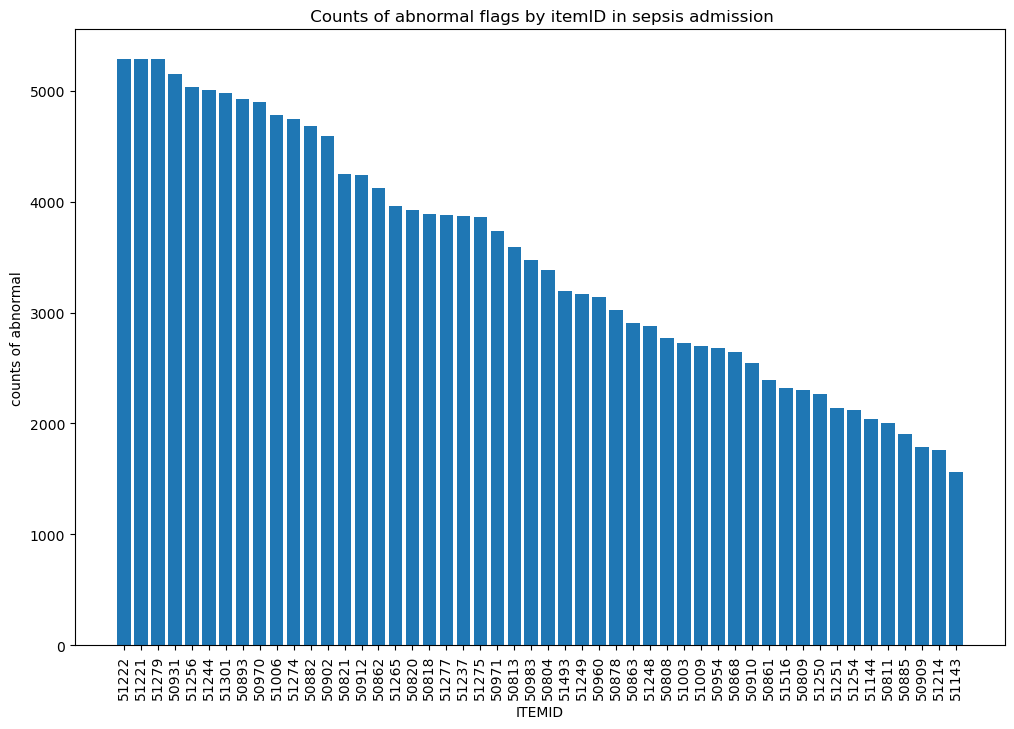

In [23]:
sorted_flags = list(sorted_dict_count.items())
top_n_flags = sorted_flags[:50]
top_n_flags = dict(top_n_flags)

keys = top_n_flags.keys()
values = top_n_flags.values()
plt.figure(figsize=(30,12))
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(keys, values)

# Set labels and title
ax.set_xlabel('ITEMID')
ax.set_ylabel('counts of abnormal')
ax.set_title(" Counts of abnormal flags by itemID in sepsis admission")
ax.set_xticklabels(result_count["ITEMID"], rotation=90)
# Show the plot
plt.show()

## Classification of labevents based on Fluid types 

In [24]:
color_mapping = {
    'Blood': 'skyblue',
    'Pleural': 'teal',
    'Ascites': 'brown',
    'Other body fluid': 'blue',
    'Urine': 'purple',
    'Joint fluid': 'orange',
    'Cerebrospinal fluid (csf)': 'pink'
    # Add more color mappings as needed
}

In [25]:
result_count['color'] = result_count['FLUID'].map(color_mapping)

C:\Users\apata\AppData\Local\Temp\ipykernel_18016\554086447.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(result_count["ITEMID"], rotation=90)


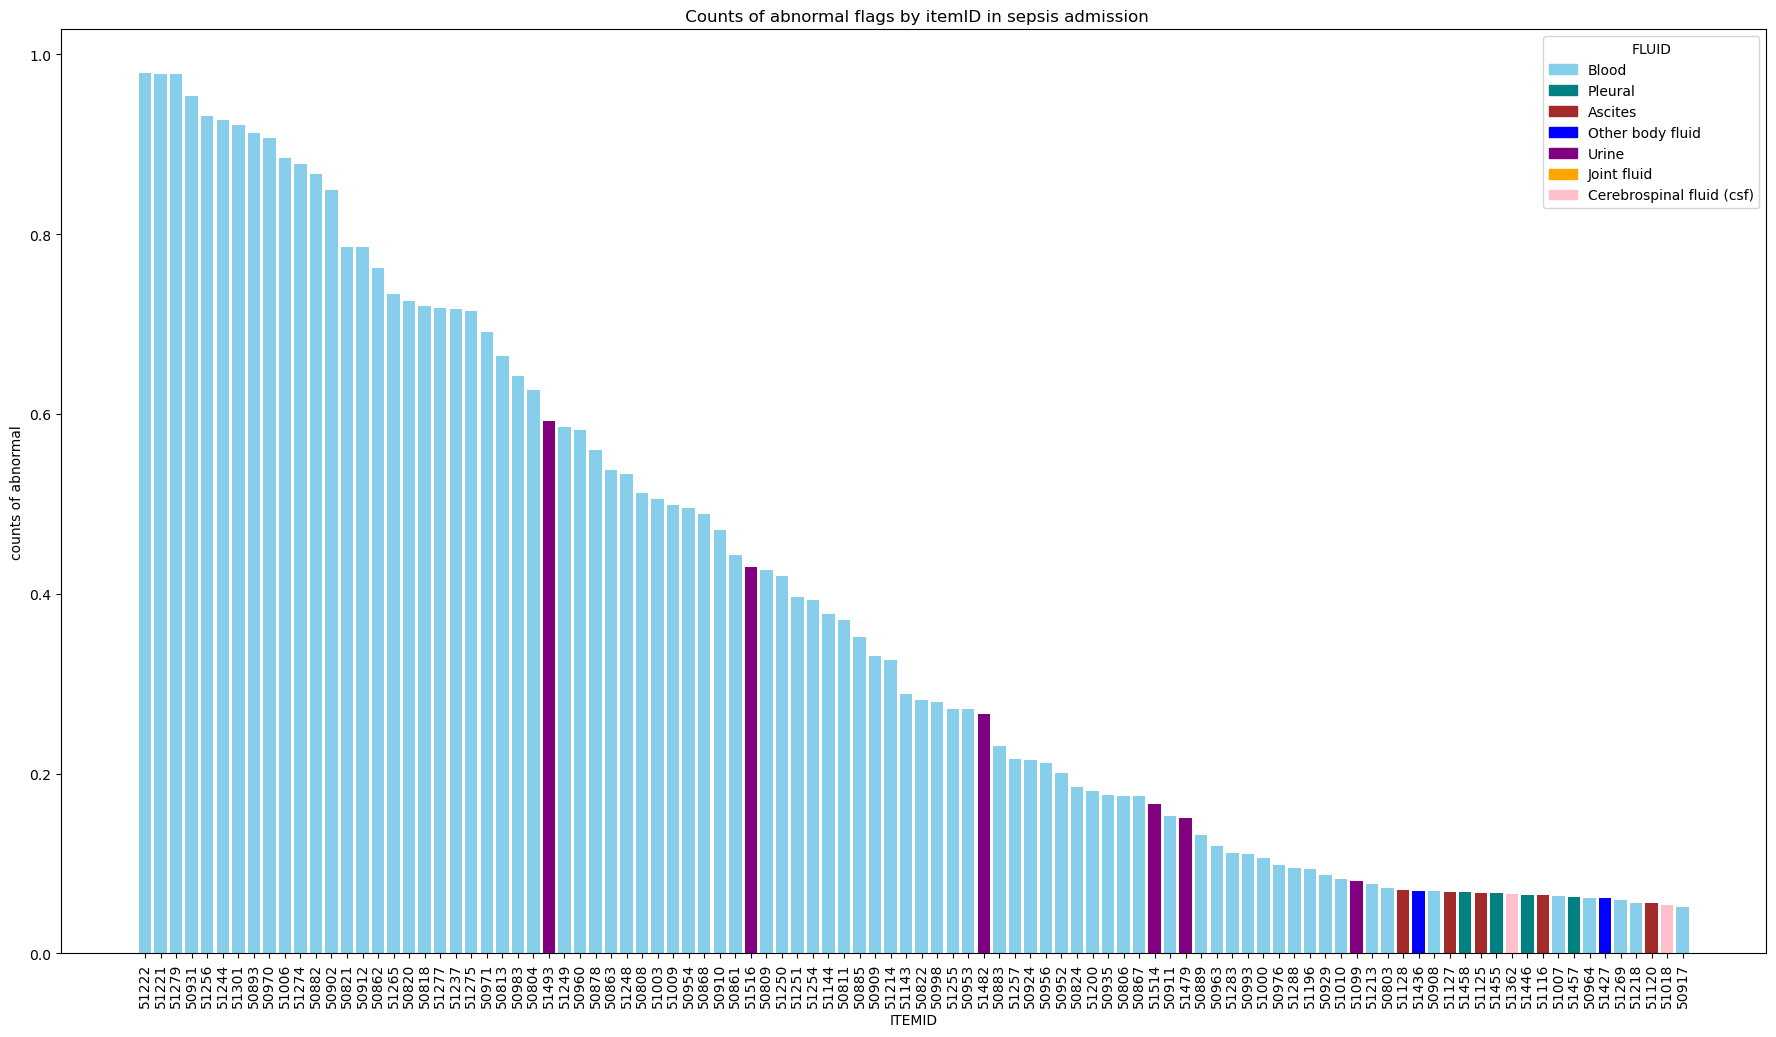

In [48]:
# show top 100
result_top = result_count[:100]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(22, 12))

# Initialize a list to store legend handles and labels
legend_handles = []

# Plot the bars with custom colors and labels
for FLUID, color in color_mapping.items():
    legend_handles.append(Patch(color=color, label=FLUID))
    #bars = result_top[result_top['FLUID'] == FLUID]
    #ax.bar(bars['FLUID'], bars['COUNT_ABNORMAL'], color=color, label=FLUID)



# Plot the bars with custom colors
bars = ax.bar(result_top['ITEMID'], result_top['COUNT_ABNORMAL']/total_sepsis, color=result_top["color"])

# Set labels and title
ax.set_xlabel('ITEMID')
ax.set_ylabel('counts of abnormal')
ax.set_title(" Counts of abnormal flags by itemID in sepsis admission")

# Show the legend
ax.legend(title='FLUID',handles=legend_handles)

ax.set_xticklabels(result_count["ITEMID"], rotation=90)
# Show the plot
plt.show()

C:\Users\apata\AppData\Local\Temp\ipykernel_18016\3710864167.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sub_df["ITEMID"], rotation=90)


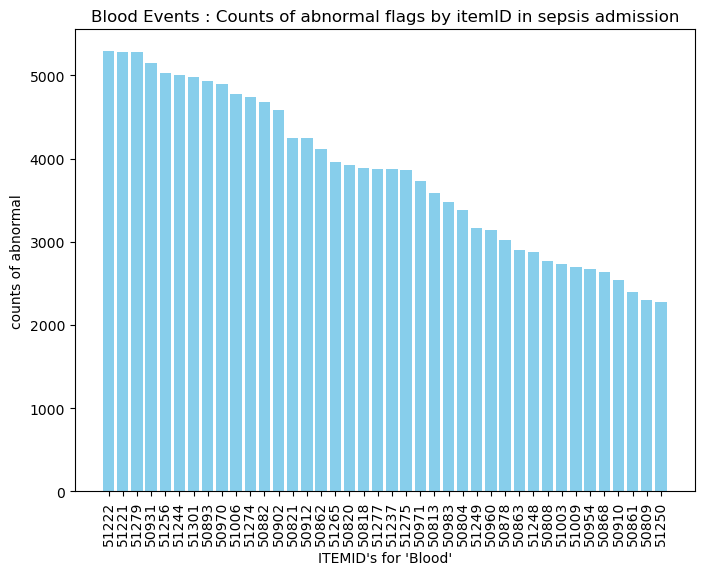

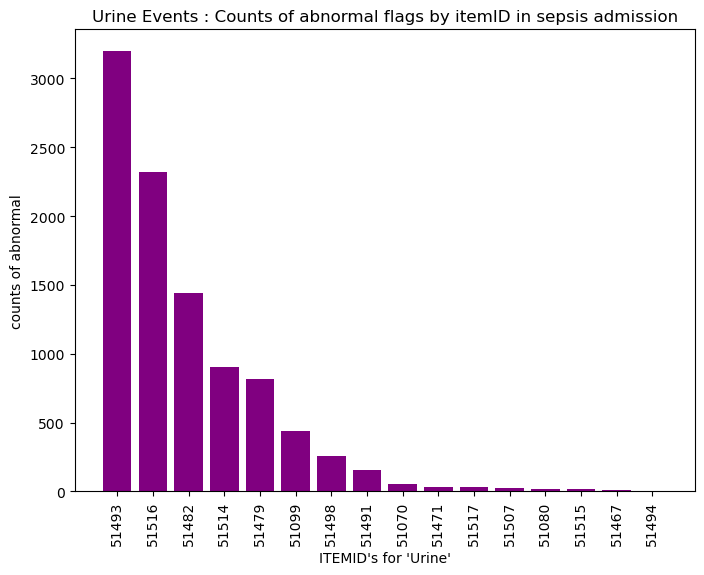

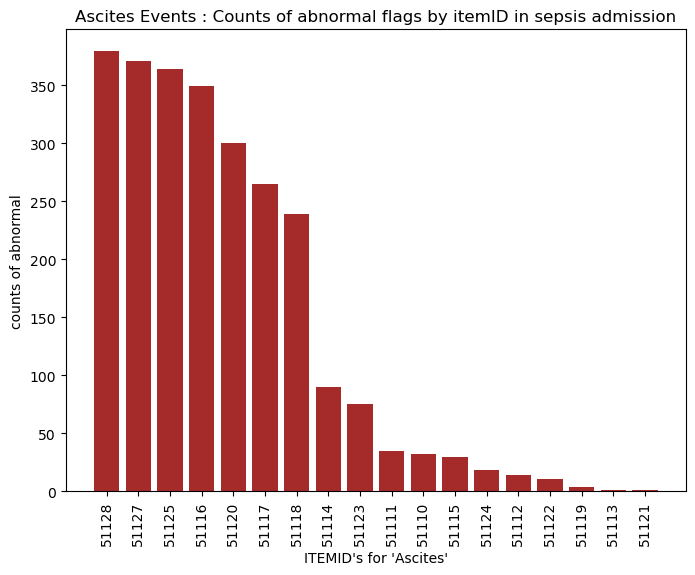

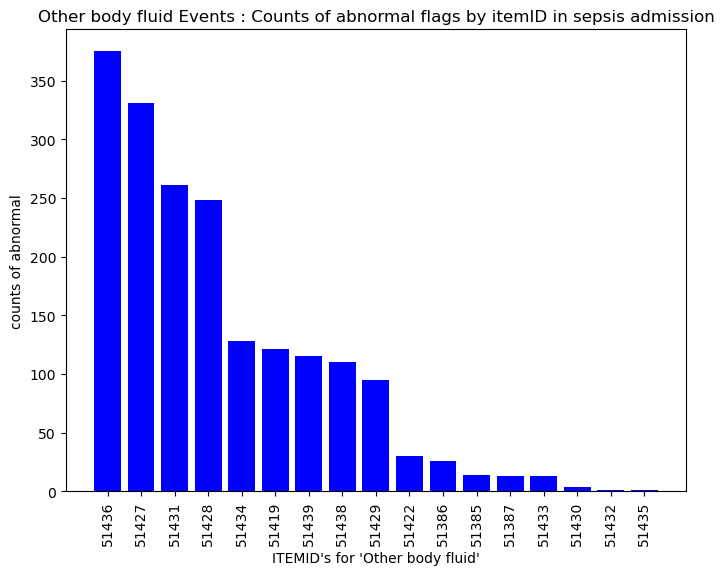

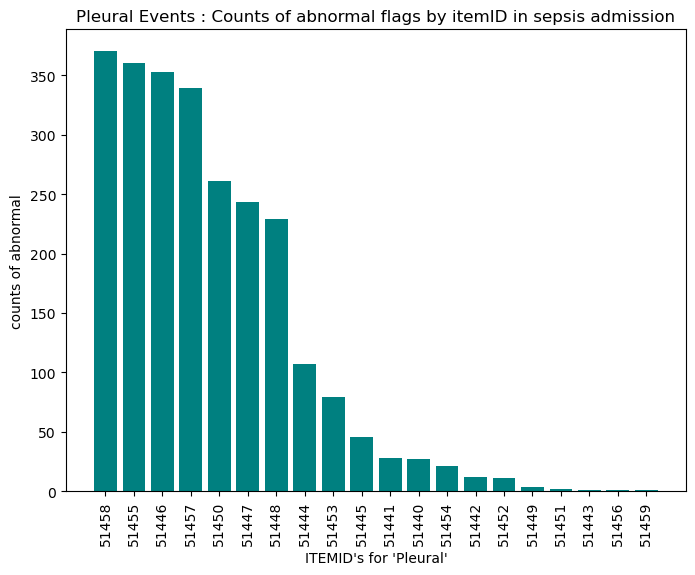

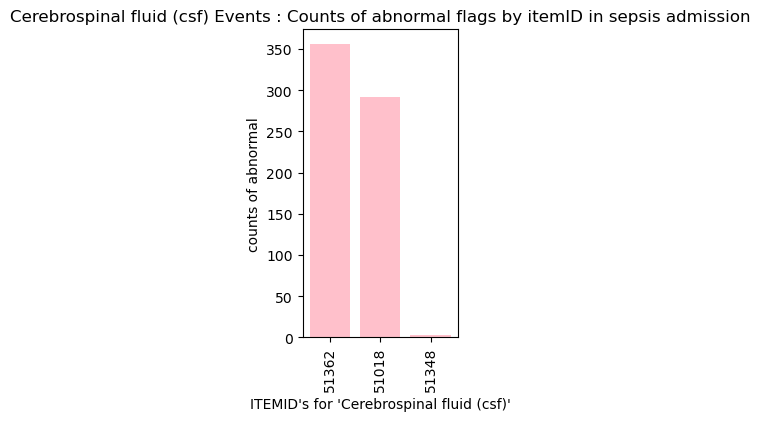

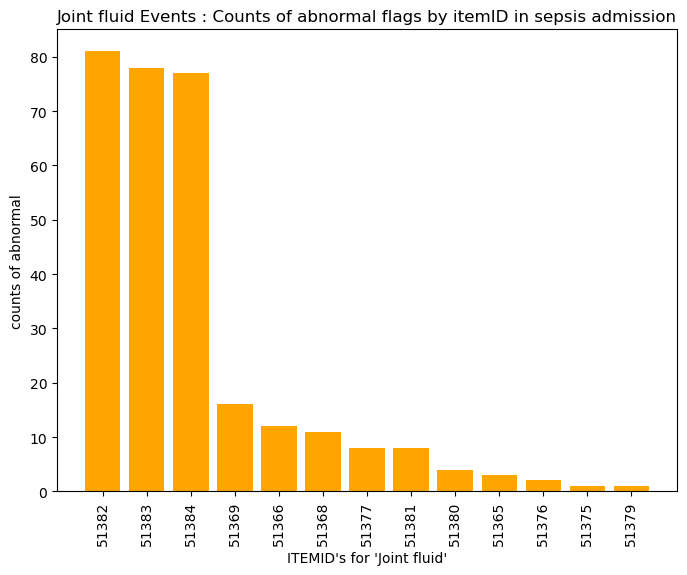

In [29]:
unique_values = result_count['FLUID'].unique()

# Create a dictionary to store DataFrames for each unique value
data_frames_by_fluid = {}

# Split the DataFrame based on unique values in 'Category2'
for value in unique_values:
    data_frames_by_fluid[value] = result_count[result_count['FLUID'] == value]

# Access DataFrames for each unique value
for value, sub_df in data_frames_by_fluid.items():
    #print(f"DataFrame for FLUID = {value}:")
   
    
    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(8, 6))
    
    if len(sub_df) > 40:
        sub_df = sub_df[:40]
    if len(sub_df) < 5:
        fig, ax = plt.subplots(figsize=(2, 4))
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
    #sub_df_30 = sub_df[:30]
    
    # Plot the bars with custom colors
    bars = ax.bar(sub_df['ITEMID'], sub_df['COUNT_ABNORMAL'], color=sub_df["color"])

    # Set labels and title
    ax.set_xlabel(f"ITEMID's for '{value}'")
    ax.set_ylabel('counts of abnormal')
    ax.set_title(f"{value} Events : Counts of abnormal flags by itemID in sepsis admission")

    

    ax.set_xticklabels(sub_df["ITEMID"], rotation=90)
    # Show the plot
    plt.show()
    print("\n")
    
    